In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline

In [2]:
# Loading the list of edge and weights
edges = pd.read_csv('diseases.csv', sep=" ")

# Converting to a list of tuples including the 'weight' attribute
tuples = [(x[0],x[1],{"weight":x[2]}) for x in edges.values]

# Making an empty graph
diseases=nx.Graph()

# Adding edges will automatically add nodes.
diseases.add_edges_from(tuples)

In [9]:
# Loading the list of node characteristics 
nodes = pd.read_table('supplementary_tableS2.txt',header=0)

# Getting rid of some extra variables we don't want to work with
nodes=nodes[['Disease ID', 'Name', 'Disorder class', 'Genes implicated (Entrez ID) [comma-deliminated]']]
print(nodes.head())

# Adding attributes to the nodes in the graph
for node in nodes['Disease ID']:
    if node in diseases.nodes():
        diseases.node[node]['name'] = nodes.loc[nodes['Disease ID']==node, 'Name'].values[0]
        diseases.node[node]['class'] = nodes.loc[nodes['Disease ID']==node, 'Disorder class'].values[0]
        diseases.node[node]['genes'] = nodes.loc[nodes['Disease ID']==node, 'Genes implicated (Entrez ID) [comma-deliminated]'].values[0]
        
print(diseases.node[9])

   Disease ID                                               Name  \
0           1                             17,20-lyase_deficiency   
1           3  2-methyl-3-hydroxybutyryl-CoA_dehydrogenase_de...   
2           4                          2-methylbutyrylglycinuria   
3           5  3-beta-hydroxysteroid_dehydrogenase,_type_II,_...   
4           6         3-hydroxyacyl-CoA_dehydrogenase_deficiency   

  Disorder class Genes implicated (Entrez ID) [comma-deliminated]  
0      Endocrine                                   CYP17A1 (1586)  
1      Metabolic                                     HADH2 (3028)  
2      Metabolic                                      ACADSB (36)  
3      Metabolic                                    HSD3B2 (3284)  
4      Metabolic                                    HADHSC (3033)  
{'name': '3-methylglutaconicaciduria', 'class': 'Metabolic', 'genes': 'OPA3 (80207)'}


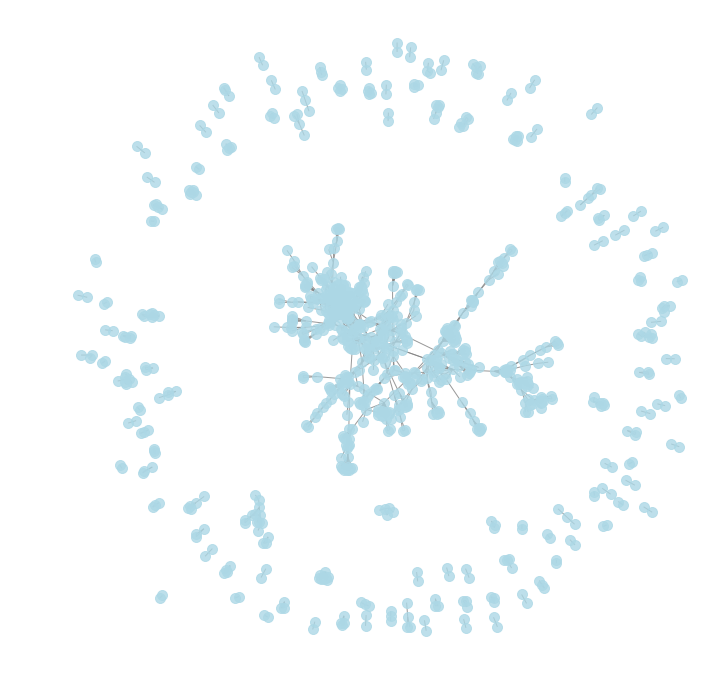

In [9]:
# Drawing the basic graph

plt.rcParams['figure.figsize']=[12,12]
nx.draw_networkx(diseases,
                pos=nx.spring_layout(diseases,weight='weights'),
                node_color='lightblue',
                edge_color='gray',
                node_size=100,
                with_labels=False,
                alpha=.8
                )

plt.axis('off')
plt.show()

This graph has 867 nodes and 1527 edges.
The median degree is 2.0 and the mean degree is 3.5224913494809686.
There are 123 connected components within the graph.


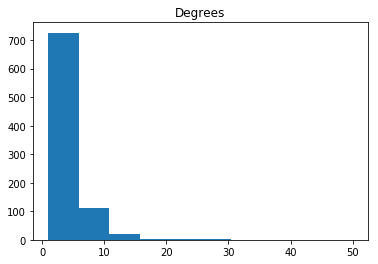

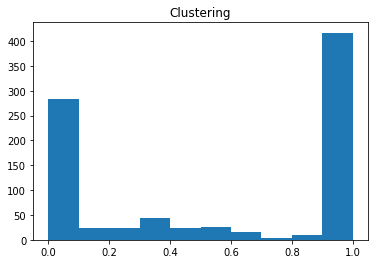

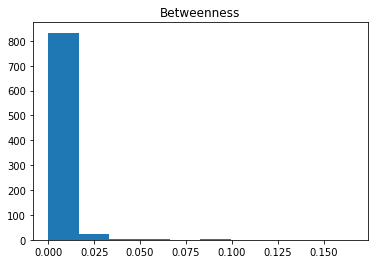

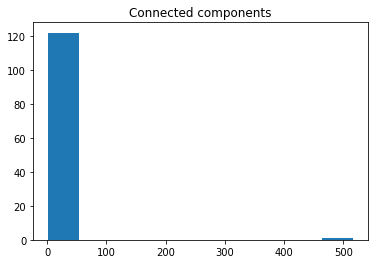

In [50]:
numberofnodes=diseases.number_of_nodes()
nodedegrees=dict(diseases.degree())
nodedegrees=list(nodedegrees.values())
av_degree=np.mean(nodedegrees)
med_degree=np.median(nodedegrees)
clustering=list(nx.clustering(diseases).values())
betweenness_cent=list(nx.betweenness_centrality(diseases).values())
componentsizes=[len(c) for c in sorted(nx.connected_components(diseases), key=len, reverse=True)]

print('This graph has {} nodes and {} edges.'.format(diseases.number_of_nodes(), diseases.number_of_edges()))
print('The median degree is {} and the mean degree is {}.'.format(med_degree, av_degree))
print('There are {} connected components within the graph.'.format(nx.number_connected_components(diseases)))

plt.rcParams['figure.figsize']=[6,4]

plt.hist(nodedegrees)
plt.title('Degrees')
plt.show()

plt.hist(clustering)
plt.title('Clustering')
plt.show()

plt.hist(betweenness_cent)
plt.title('Betweenness')
plt.show()

plt.hist(componentsizes)
plt.title('Connected components')
plt.show()

In [64]:
nodedegrees=dict(diseases.degree())


# Pulling our node-level statistics together into a dataframe
graph_stats=pd.DataFrame({'node':list(nodedegrees.keys()),
                         'degree':list(nodedegrees.values()),
                         'clustering':list(nx.clustering(diseases).values()),
                         'betweenness_cent':list(nx.betweenness_centrality(diseases).values())
                         })

# Assigning each node to a component by number
graph_stats['component']=None

# Sorting the components by size so that the largest component will be numbered 0
components=sorted(nx.connected_components(diseases), key=len, reverse=True)
for i,component in enumerate(components):
    graph_stats.loc[graph_stats['node'].isin(list(component)),'component']=i
    
print(graph_stats.head(15))

    node  degree  clustering  betweenness_cent  component
0      9       1    0.000000          0.000000          0
1   1144       2    0.000000          0.001372          0
2     13       1    0.000000          0.000000          0
3    990      14    0.186813          0.012232          0
4     14       2    1.000000          0.000000         24
5    121       2    1.000000          0.000000         24
6   1446       2    1.000000          0.000000         24
7     15       2    1.000000          0.000000          0
8    681       9    0.250000          0.014224          0
9   1573       4    0.333333          0.002739          0
10    17       2    1.000000          0.000000          0
11   724       3    0.333333          0.002739          0
12   763       2    1.000000          0.000000          0
13    18       1    0.000000          0.000000         54
14   255       1    0.000000          0.000000         54


In [70]:
graph_stats.loc[graph_stats['node'] == 2055]


,node,degree,clustering,betweenness_cent,component
852,2055,1,0.0,0.0,121


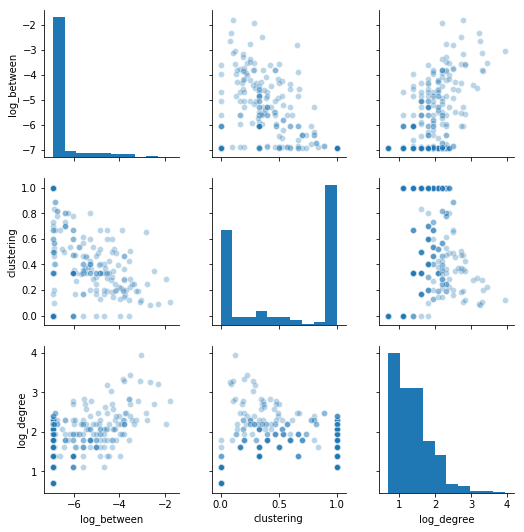

In [57]:
# Logging these two for easier relationship viewing.
graph_stats['log_between']=np.log(graph_stats['betweenness_cent']+.001)
graph_stats['log_degree']=np.log(graph_stats['degree']+1)

g = sns.pairplot(graph_stats,
                 vars=['log_between','clustering','log_degree'],
                 kind='scatter',
                plot_kws={'alpha':.3})
plt.show()

In [82]:
# Merging our statistics with the original node information
disease_stats=pd.merge(graph_stats,nodes,left_on='node',right_on='Disease ID',how='outer')

print(disease_stats.head())

     node  degree  clustering  betweenness_cent  component  Disease ID  \
0     9.0     1.0    0.000000          0.000000        0.0           9   
1  1144.0     2.0    0.000000          0.001372        0.0        1144   
2    13.0     1.0    0.000000          0.000000        0.0          13   
3   990.0    14.0    0.186813          0.012232        0.0         990   
4    14.0     2.0    1.000000          0.000000       24.0          14   

                         Name   Disorder class  \
0  3-methylglutaconicaciduria        Metabolic   
1               Optic_atrophy  Ophthamological   
2      Aarskog-Scott_syndrome         multiple   
3          Mental_retardation     Neurological   
4   Abacavir_hypersensitivity    Immunological   

    Genes implicated (Entrez ID) [comma-deliminated]  
0                                       OPA3 (80207)  
1                          OPA1 (4976), OPA3 (80207)  
2                                        FGD1 (2245)  
3  PRSS12 (8492), CRBN (51185), NL

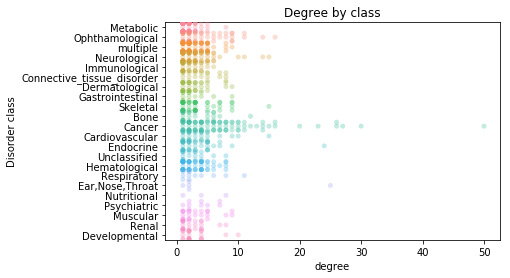

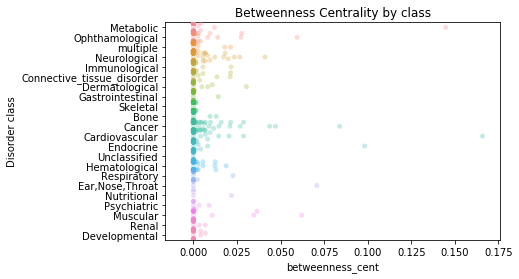

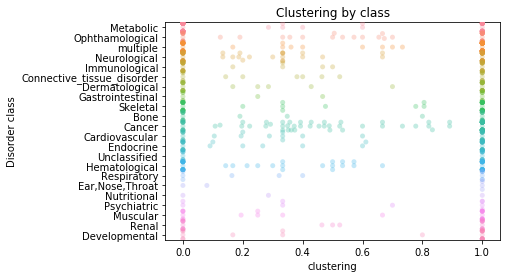

In [83]:
# Plotting node stats by class

sns.swarmplot(x='degree', y='Disorder class', data=disease_stats,alpha=.3)
plt.title('Degree by class')
plt.show()

sns.swarmplot(x='betweenness_cent', y='Disorder class', data=disease_stats,alpha=.3)
plt.title('Betweenness Centrality by class')
plt.show()

sns.swarmplot(x='clustering', y='Disorder class', data=disease_stats,alpha=.3)
plt.title('Clustering by class')
plt.show()


In [85]:
print('The number of nodes in each class:')
nodesbyclass = disease_stats.groupby(by='Disorder class')['component'].count()
print(nodesbyclass)

print('\nThe number of connected componenets that members of each class belong to.')
componentsbyclass=disease_stats.groupby(by='Disorder class')['component'].apply(lambda x: len(set(x)))
print(componentsbyclass)

# A class with more nodes has more opportunities to belong to multiple components, so we'll divide by number of nodes.
print('\nNumber of components by class normalized by number of nodes.')
print(componentsbyclass/nodesbyclass)

The number of nodes in each class:
Disorder class
Bone                           24
Cancer                         99
Cardiovascular                 33
Connective_tissue_disorder     20
Dermatological                 37
Developmental                  23
Ear,Nose,Throat                 5
Endocrine                      40
Gastrointestinal               14
Hematological                  67
Immunological                  39
Metabolic                      91
Muscular                       22
Neurological                   78
Nutritional                     3
Ophthamological                48
Psychiatric                     9
Renal                          22
Respiratory                    12
Skeletal                       53
Unclassified                   18
multiple                      110
Name: component, dtype: int64

The number of connected componenets that members of each class belong to.
Disorder class
Bone                           14
Cancer                         23
Cardiovascular

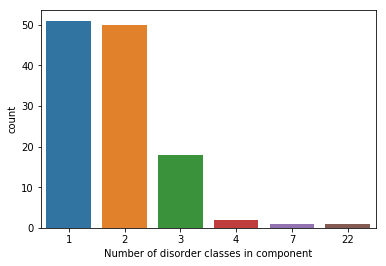

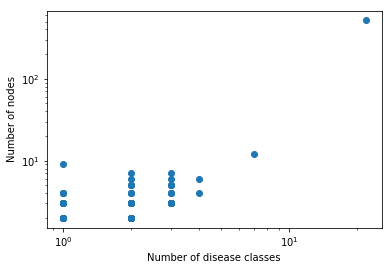

component
2.0         [Hematological, 9]
17.0            [Metabolic, 4]
19.0            [Metabolic, 4]
21.0             [Skeletal, 4]
34.0            [Metabolic, 3]
41.0        [Hematological, 3]
42.0        [Hematological, 3]
47.0            [Metabolic, 3]
50.0            [Metabolic, 3]
52.0       [Dermatological, 3]
53.0          [Respiratory, 3]
54.0             [Skeletal, 2]
55.0       [Dermatological, 2]
57.0       [Dermatological, 2]
59.0             [Muscular, 2]
60.0                [Renal, 2]
61.0        [Hematological, 2]
62.0     [Gastrointestinal, 2]
63.0        [Hematological, 2]
66.0         [Neurological, 2]
67.0        [Hematological, 2]
69.0        [Hematological, 2]
70.0             [Muscular, 2]
72.0      [Ophthamological, 2]
74.0                 [Bone, 2]
75.0         [Neurological, 2]
76.0     [Gastrointestinal, 2]
77.0            [Metabolic, 2]
80.0             [Skeletal, 2]
81.0            [Metabolic, 2]
82.0       [Cardiovascular, 2]
84.0            [Metabolic, 2

In [90]:
# Count of nodes in components
nodesbycomponent=disease_stats.groupby(by='component')['Disorder class'].count()

# The number of classes that members of each component belong to.
classesbycomponent=disease_stats.groupby(by='component')['Disorder class'].apply(lambda x: len(set(x)))

sns.countplot(classesbycomponent)
plt.xlabel('Number of disorder classes in component')
plt.show()

# Plotting number of classes in a component by size of component
fig = plt.figure()
ax = plt.gca()
ax.scatter(classesbycomponent, nodesbycomponent)
# Using log scales because of outliers
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('Number of disease classes')
plt.ylabel('Number of nodes')
plt.show()

# List of homogenous components that contain only one class
homogenous=classesbycomponent[classesbycomponent==1].index

# The number of nodes and class of homogenous component:
componentclasses=disease_stats[disease_stats['component']
                               .isin(list(homogenous))].groupby(by='component')['Disorder class'].apply(lambda x: [list(set(x))[0],len(x)])

print(componentclasses)

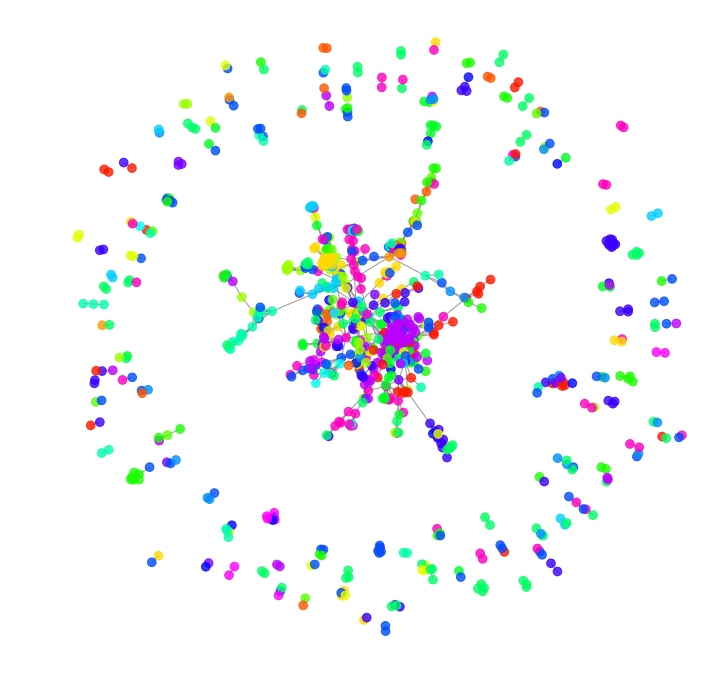

In [92]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# Getting a list of all the nodes' classes, in order
classlist=list(nx.get_node_attributes(diseases,'class').values())

# Creating a dictionary associating each class with a unique integer
classes=set(classlist)
dictionary=dict(zip(classes,range(len(classes))))

# Creating a list of integers corresponding to classes to use for color assignment
classcolors=[dictionary[x] for x in classlist]

plt.rcParams['figure.figsize']=[12,12]

nx.draw_networkx(diseases,
                pos=nx.spring_layout(diseases,weight='weights'),
                cmap=plt.get_cmap('gist_rainbow'),
                node_color=classcolors,
                edge_color='gray',
                node_size=75,
                with_labels=False,
                alpha=.8
                )

plt.axis('off')
plt.show()